# <a id='toc1_'></a>[Efficiency Analysis](#toc0_)
This notebook demonstrates the use of `EfficiencyAnalysis` class in `src/analysis/efficiency_analysis.py` for analyzing the efficiency of jobs, users, and PI groups.

**Table of contents**<a id='toc0_'></a>    
- [Efficiency Analysis](#toc1_)    
  - [Setup](#toc1_1_)    
  - [Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc1_2_)    
    - [Job Efficiency Metrics](#toc1_2_1_)    
      - [Find most inefficient jobs with no VRAM constraints based on `vram_hours`](#toc1_2_1_1_)    
    - [User Efficiency Metrics](#toc1_2_2_)    
      - [Find Inefficient Users based on `expected_value_alloc_vram_efficiency`](#toc1_2_2_1_)    
      - [Find Inefficient Users based on `vram_hours`](#toc1_2_2_2_)    
    - [PI Group Efficiency Metrics](#toc1_2_3_)    
      - [Find Inefficient PIs based on `vram_hours`](#toc1_2_3_1_)    
  - [Example: Analyze all jobs with no VRAM constraints](#toc1_3_)    
    - [Job Efficiency Metrics](#toc1_3_1_)    
      - [Problem with duplicate JobIDs](#toc1_3_1_1_)    
      - [Top users with most number of jobs that have no VRAM constraints](#toc1_3_1_2_)    
      - [Find inefficient jobs with no VRAM Constraints based on `alloc_vram_efficiency_score`](#toc1_3_1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

In [1]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Jupyter server should be run at the notebook directory, so the output of the following cell would be the project root:

In [2]:
project_root = str(Path.cwd().resolve().parent)
print(f"Project root: {project_root}")

Project root: C:\Users\Nitya Karthik A\ds4cg-job-analytics


In [3]:
# Add project root to sys.path for module imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analysis import efficiency_analysis as ea
from src.visualization import JobsWithMetricsVisualizer, UsersWithMetricsVisualizer

# Automatically reload modules before executing code
# This is useful for development to see changes without restarting the kernel.
%load_ext autoreload
# Reload all modules imported with %aimport every time before executing the Python code typed.
%autoreload 2

In [4]:
# Load the jobs DataFrame from DuckDB
preprocessed_jobs_df = ea.load_preprocessed_jobs_dataframe_from_duckdb(
    db_path='../data/slurm_data.db',
    table_name='Jobs',
    )
display(preprocessed_jobs_df.head(10))
print(preprocessed_jobs_df.shape)

Connected to ../data/slurm_data.db
[Preprocessing] Running with new database format: GPU types as dictionary.
Disconnected from ../data/slurm_data.db


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
2,38482061,<NA>,-1,joby42h-n,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,0.0,2.576670e+10,99.143585,3 days 01:23:00,<NA>,<NA>,<NA>,320,959,1309
22,38634311,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,88.0,5.945262e+08,99.912697,0 days 00:00:18,<NA>,<NA>,<NA>,11,118912,118912
23,38634905,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,88.0,6.020669e+08,99.949554,0 days 00:00:31,<NA>,<NA>,<NA>,11,118912,118912
24,38634906,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,90.0,6.128353e+08,99.956528,0 days 00:00:20,<NA>,<NA>,<NA>,11,118912,118912
25,38634956,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,90.0,5.236490e+08,99.956741,0 days 00:00:26,<NA>,<NA>,<NA>,11,118912,118912
26,38634965,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,89.0,6.643016e+08,99.956139,0 days 00:00:17,<NA>,<NA>,<NA>,11,118912,118912
27,38641028,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,90.0,5.166858e+08,99.957039,0 days 00:00:13,<NA>,<NA>,<NA>,11,118912,118912
75,38689004,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,6.888489e+08,6.247138,0 days 00:00:19,<NA>,16,16,16,4507,9657
76,38689007,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,7.478968e+08,6.247185,0 days 00:00:03,<NA>,16,16,16,4507,9657
77,38689021,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,7.148012e+08,6.247218,0 days 00:00:08,<NA>,16,16,16,4507,9657


(1120587, 33)


## <a id='toc1_2_'></a>[Example: Analyze workload efficiency of GPU users who set no VRAM constraints and used 0 GB of VRAM](#toc0_)


In [5]:
efficiency_analysis = ea.EfficiencyAnalysis(
	jobs_df=preprocessed_jobs_df
)

In [6]:
filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter=pd.NA,  # No VRAM constraints
    gpu_mem_usage_filter=0,  # Used 0 GB of VRAM
)
filtered_jobs

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
2,38482061,<NA>,-1,joby42h-n,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,...,0.0,2.576670e+10,99.143585,3 days 01:23:00,<NA>,<NA>,<NA>,320,959,1309
75,38689004,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,6.888489e+08,6.247138,0 days 00:00:19,<NA>,16,16,16,4507,9657
76,38689007,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,7.478968e+08,6.247185,0 days 00:00:03,<NA>,16,16,16,4507,9657
77,38689021,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,7.148012e+08,6.247218,0 days 00:00:08,<NA>,16,16,16,4507,9657
78,38689028,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,...,0.0,7.644774e+08,6.247029,0 days 00:00:20,<NA>,16,16,16,4507,9657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11123556,40132522,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,0.0,2.512732e+08,99.968605,0 days 00:35:17,<NA>,<NA>,<NA>,11,118912,118912
11123623,40132645,<NA>,-1,job.sh,False,non-interactive,pi_grason_umass_edu,rvmathew_umass_edu,['2080ti'],normal,...,0.0,2.437243e+08,99.955017,0 days 00:34:44,<NA>,<NA>,<NA>,11,118912,118912
11123625,40132655,<NA>,-1,interactive,False,shell,pi_sniekum_umass_edu,ttripathi_umass_edu,[],normal,...,0.0,0.000000e+00,0.000000,0 days 00:00:31,<NA>,80,80,80,652,27410
11123631,40132681,<NA>,-1,bash,False,shell,pi_sunghoonlee_umass_edu,ptarale_umass_edu,['2080ti'],normal,...,0.0,0.000000e+00,0.000000,0 days 00:00:31,<NA>,<NA>,<NA>,11,941,41374


Generate all metrics:

In [7]:
metrics_dict = efficiency_analysis.calculate_all_efficiency_metrics(filtered_jobs)

jobs_with_metrics = metrics_dict['jobs_with_efficiency_metrics']
users_with_metrics = metrics_dict['users_with_efficiency_metrics']
pi_accounts_with_metrics = metrics_dict['pi_accounts_with_efficiency_metrics']

### <a id='toc1_2_1_'></a>[Job Efficiency Metrics](#toc0_)

In [8]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')

print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
2,38482061,<NA>,-1,joby42h-n,False,non-interactive,pi_zhangl_uri_edu,zhangl_uri_edu,['avx512'],long,COMPLETED,SUCCESS,2025-06-22 18:12:07,2025-06-25 19:35:07,1 days 06:31:27,0 days 00:48:00,gpu,[uri-gpu002],64,4,{'a100': 4},0.0,0.0,99.143585,3 days 01:23:00,<NA>,<NA>,<NA>,320,959,1309,122.096667,39070.933333,0.0,0.0,<NA>,-inf,<NA>,23.997108,503.369141,0.047673
75,38689004,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,COMPLETED,SUCCESS,2025-06-25 22:29:42,2025-06-25 22:30:01,1 days 01:30:24,0 days 00:48:00,power9-gpu-preempt,[power9-gpu014],16,1,{'v100': 1},0.0,0.0,6.247138,0 days 00:00:19,<NA>,16,16,16,4507,9657,25.506667,408.106667,0.0,0.0,<NA>,-inf,<NA>,0.641541,8.000000,0.080193
76,38689007,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,COMPLETED,SUCCESS,2025-06-25 22:30:29,2025-06-25 22:30:32,1 days 01:29:47,0 days 00:48:00,power9-gpu-preempt,[power9-gpu015],16,1,{'v100': 1},0.0,0.0,6.247185,0 days 00:00:03,<NA>,16,16,16,4507,9657,25.496389,407.942222,0.0,0.0,<NA>,-inf,<NA>,0.696533,8.000000,0.087067
77,38689021,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,COMPLETED,SUCCESS,2025-06-25 22:31:17,2025-06-25 22:31:25,1 days 01:32:02,0 days 00:48:00,power9-gpu-preempt,[power9-gpu015],16,1,{'v100': 1},0.0,0.0,6.247218,0 days 00:00:08,<NA>,16,16,16,4507,9657,25.533889,408.542222,0.0,0.0,<NA>,-inf,<NA>,0.665710,8.000000,0.083214
78,38689028,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,COMPLETED,SUCCESS,2025-06-25 22:32:05,2025-06-25 22:32:25,1 days 01:30:24,0 days 00:48:00,power9-gpu-preempt,[power9-gpu016],16,1,{'v100': 1},0.0,0.0,6.247029,0 days 00:00:20,<NA>,16,16,16,4507,9657,25.506667,408.106667,0.0,0.0,<NA>,-inf,<NA>,0.711975,8.000000,0.088997
79,38689035,<NA>,-1,emri,False,non-interactive,pi_gkhanna_uri_edu,gkhanna_uri_edu,[],normal,COMPLETED,SUCCESS,2025-06-25 22:32:52,2025-06-25 22:33:04,1 days 01:27:18,0 days 00:48:00,power9-gpu-preempt,[power9-gpu016],16,1,{'v100': 1},0.0,0.0,6.247132,0 days 00:00:12,<NA>,16,16,16,4507,9657,25.455,407.28,0.0,0.0,<NA>,-inf,<NA>,0.707886,8.000000,0.088486
327,38754140,<NA>,-1,bash,False,shell,pi_mfiterau_umass_edu,sidongzhang_umass_edu,[],normal,TIMEOUT,SUCCESS,2025-06-26 17:12:22,2025-06-26 17:12:25,0 days 08:00:15,0 days 00:08:00,gpu,[gypsum-gpu015],1,1,{'m40': 1},0.0,0.0,0.011690,0 days 00:00:03,<NA>,<NA>,<NA>,23,5651,38414,8.004167,184.095833,0.0,0.0,<NA>,-inf,<NA>,0.109863,80.000000,0.001373
329,38754197,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,[],normal,TIMEOUT,SUCCESS,2025-06-26 17:22:46,2025-06-26 17:23:06,0 days 08:00:05,0 days 00:08:00,gpu,[gypsum-gpu153],8,1,{'1080_ti': 1},0.0,0.0,0.001303,0 days 00:00:20,<NA>,<NA>,<NA>,11,140,9822,8.001389,88.015278,0.0,0.0,<NA>,-inf,<NA>,0.045361,20.000000,0.002268
342,38754976,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_dganesan_umass_edu,mrastikerdar_umass_edu,['x86_64'],gpu-quota-8,TIMEOUT,SUCCESS,2025-06-26 18:00:58,2025-06-26 18:00:59,0 days 08:00:12,0 days 00:08:00,gpupod-l40s,[gpu039],4,1,{'l40s': 1},0.0,0.0,1.287782,0 days 00:00:01,<NA>,48,48,48,1654,2691,8.003333,384.16,0.0,0.0,<NA>,-inf,<NA>,11.664204,100.000000,0.116642
378,38760887,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_shenoy_umass_edu,bchhaglani_umass_edu,['sm_70'],normal,TIMEOUT,SUCCESS,2025-06-26 19:22:05,2025-06-26 19:22:35,0 days 08:00:10,0 days 00:08:00,gpu,[gpu003]

Jobs found: 123445


#### <a id='toc1_2_1_1_'></a>[Find most inefficient jobs with no VRAM constraints based on `vram_hours`](#toc0_)


Top inefficient Jobs by VRAM-hours:


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
9614818,39728977,<NA>,-1,ccc_scaling,False,non-interactive,pi_hrando_smith_edu,qhe_smith_edu,"['1080ti', 'amd1900x', 'amd7402', 'amd7502', '...",normal,...,927.342222,652848.924444,0.0,0.0,<NA>,-inf,<NA>,124.943695,2960.000000,0.042211
9598261,39729122,<NA>,-1,ccc_scaling,False,non-interactive,pi_hrando_smith_edu,qhe_smith_edu,"['1080ti', 'amd1900x', 'amd7402', 'amd7502', '...",normal,...,615.875556,433576.391111,0.0,0.0,<NA>,-inf,<NA>,96.790817,2960.000000,0.032700
9774143,25094304,<NA>,-1,trainunity.sh,False,non-interactive,pi_ashgiri_uri_edu,achyut_subedi_uri_edu,[],normal,...,1344.018889,430086.044444,0.0,0.0,<NA>,-inf,<NA>,6.600376,500.000000,0.013201
9312665,25663846,<NA>,-1,1e4-bw6,False,non-interactive,pi_candela_umass_edu,ejdwight_umass_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",long,...,2880.043333,414726.24,0.0,0.0,<NA>,-inf,<NA>,2.453487,43.945312,0.055830
9312666,25663945,<NA>,-1,1e4coulhDeltaMX,False,non-interactive,pi_candela_umass_edu,ejdwight_umass_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",long,...,2880.03,414724.32,0.0,0.0,<NA>,-inf,<NA>,13.604195,43.945312,0.309571
10503565,24689859,<NA>,-1,BATCH_SCRIPT,False,non-interactive,pi_erno_sajo_uml_edu,diana_thompson_student_uml_edu,[],normal,...,342.016667,410420.0,0.0,0.0,<NA>,-inf,<NA>,6.856304,16.000000,0.428519
526810,38149589,<NA>,-1,glide-dock_chain_B.sh,False,non-interactive,pi_xiaohuizhang_umass_edu,hhargrove_umass_edu,[],normal,...,384.071111,294966.613333,0.0,0.0,<NA>,-inf,<NA>,2.984634,40.000000,0.074616
9374024,25663852,<NA>,-1,1e4-bw5,False,non-interactive,pi_candela_umass_edu,ejdwight_umass_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",long,...,2014.62,290105.28,0.0,0.0,<NA>,-inf,<NA>,2.430229,43.945312,0.055301
9582902,39729136,<NA>,-1,ccc_scaling,False,non-interactive,pi_hrando_smith_edu,qhe_smith_edu,"['1080ti', 'amd1900x', 'amd7402', 'amd7502', '...",normal,...,397.493333,279835.306667,0.0,0.0,<NA>,-inf,<NA>,124.548203,2960.000000,0.042077
10948874,39976257,<NA>,-1,ccc_scaling,False,non-interactive,pi_hrando_smith_edu,qhe_smith_edu,"['1080ti', 'amd1900x', 'amd7402', 'amd7502', '...",normal,...,392.942222,276631.324444,0.0,0.0,<NA>,-inf,<NA>,133.373840,2960.000000,0.045059


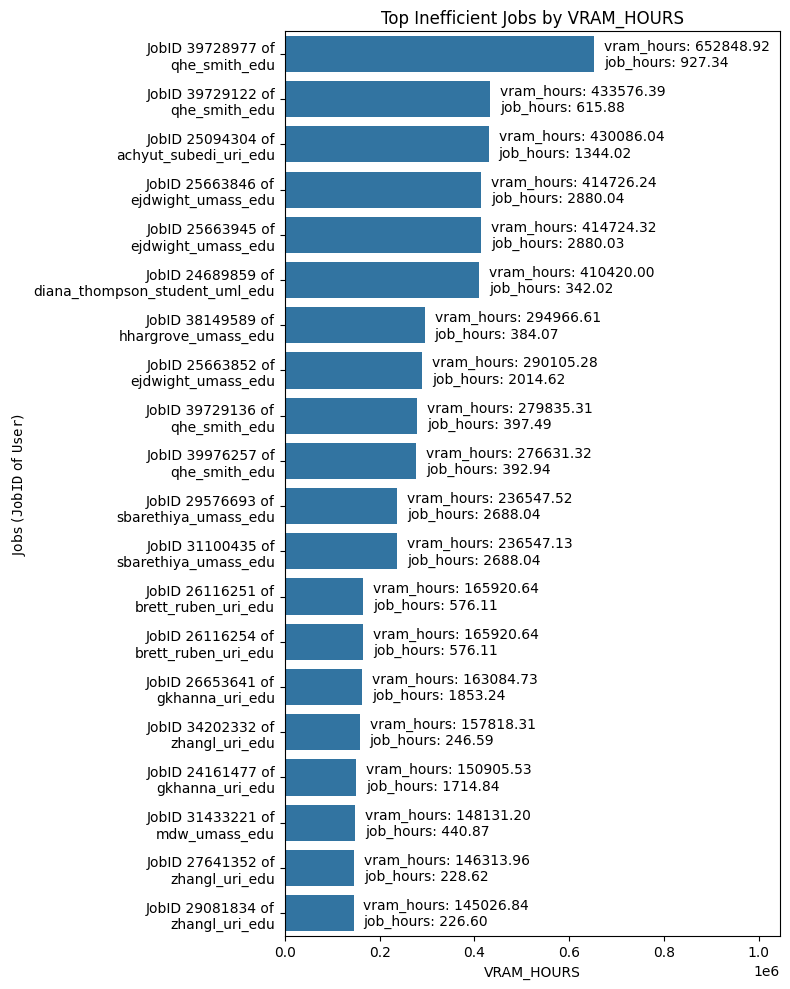

In [9]:
inefficient_jobs_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.JOBS,
    sorting_key="vram_hours",
    ascending=False,  # Sort by vram_hours in descending order
    filter_criteria={
        "vram_hours": {"min": 80 * 24, "inclusive": True},  # VRAM-hours threshold for identifying inefficient jobs
    }
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient Jobs by VRAM-hours:")
display(inefficient_jobs_vram_hours.head(10))

# Plot top inefficient jobs by VRAM-hours, with VRAM-hours as labels
jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(inefficient_jobs_vram_hours.head(20))
jobs_with_metrics_visualizer.visualize(
    column="vram_hours",
    bar_label_columns=["vram_hours", "job_hours"],
)



### <a id='toc1_2_2_'></a>[User Efficiency Metrics](#toc0_)

In [10]:
users_with_metrics

,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
0,aabedeen_umass_edu,1,8.005,pi_pkatz_umass_edu,<NA>,<NA>,0.0,<NA>,12.000000,96.060000
1,aaditya_umass_edu,125,963.803333,pi_dganesan_umass_edu,<NA>,<NA>,0.0,<NA>,44.703554,43085.434444
2,aanjali_umass_edu,4,4.704444,pi_jtaneja_umass_edu,<NA>,<NA>,0.0,<NA>,16.532357,77.775556
3,aaron_fishbein_uml_edu,47,795.030833,pi_erno_sajo_uml_edu,<NA>,<NA>,0.0,<NA>,818.367001,73026.567778
4,aaronsun_umass_edu,190,6552.118611,pi_smaji_umass_edu,<NA>,<NA>,0.0,<NA>,55.227180,230986.070278
...,...,...,...,...,...,...,...,...,...,...
767,zonghaiyao_umass_edu,1,18.952222,pi_hongyu_umass_edu,<NA>,<NA>,0.0,<NA>,11.000000,208.474444
768,zplumridge_smith_edu,2,4.349444,pi_hrando_smith_edu,<NA>,<NA>,0.0,<NA>,71.632648,155.781111
769,zshah_umass_edu,4,24.011667,pi_jtaneja_umass_edu,<NA>,<NA>,0.0,<NA>,11.499977,276.133611
770,zubin_bhuyan_student_uml_edu,5,5.802778,pi_yuanchang_xie_uml_edu,<NA>,<NA>,0.0,<NA>,48.000000,278.533333


#### <a id='toc1_2_2_1_'></a>[Find Inefficient Users based on `expected_value_alloc_vram_efficiency`](#toc0_)


Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
1,aaditya_umass_edu,125,963.803333,pi_dganesan_umass_edu,<NA>,<NA>,0.0,<NA>,44.703554,43085.434444
3,aaron_fishbein_uml_edu,47,795.030833,pi_erno_sajo_uml_edu,<NA>,<NA>,0.0,<NA>,818.367001,73026.567778
4,aaronsun_umass_edu,190,6552.118611,pi_smaji_umass_edu,<NA>,<NA>,0.0,<NA>,55.227180,230986.070278
5,aarunachalam_umass_edu,6,5.371389,pi_etaffet_umass_edu,<NA>,<NA>,0.0,<NA>,11.813053,63.452500
6,aarushimahaj_umass_edu,5,8.141667,pi_burleson_umass_edu,<NA>,<NA>,0.0,<NA>,19.307131,157.192222
9,aatmakuru_umass_edu,41,967.938889,pi_hzamani_umass_edu,<NA>,<NA>,0.0,<NA>,246.934935,62170.558889
10,abdelrahman_eljamal_uri_edu,12,104.180556,pi_csc592_uri_edu,<NA>,<NA>,0.0,<NA>,522.180728,7816.421667
11,abdullaharafat_miah_uri_edu,6,72.018889,pi_yu_bi_uri_edu,<NA>,<NA>,0.0,<NA>,598.045285,12339.890278
15,absahoo_umass_edu,47,99.285833,pi_mccallum_umass_edu,<NA>,<NA>,0.0,<NA>,35.072840,3482.236111
18,achatt_uri_edu,7,218.631111,pi_csc561_uri_edu,<NA>,<NA>,0.0,<NA>,542.327065,17513.455556


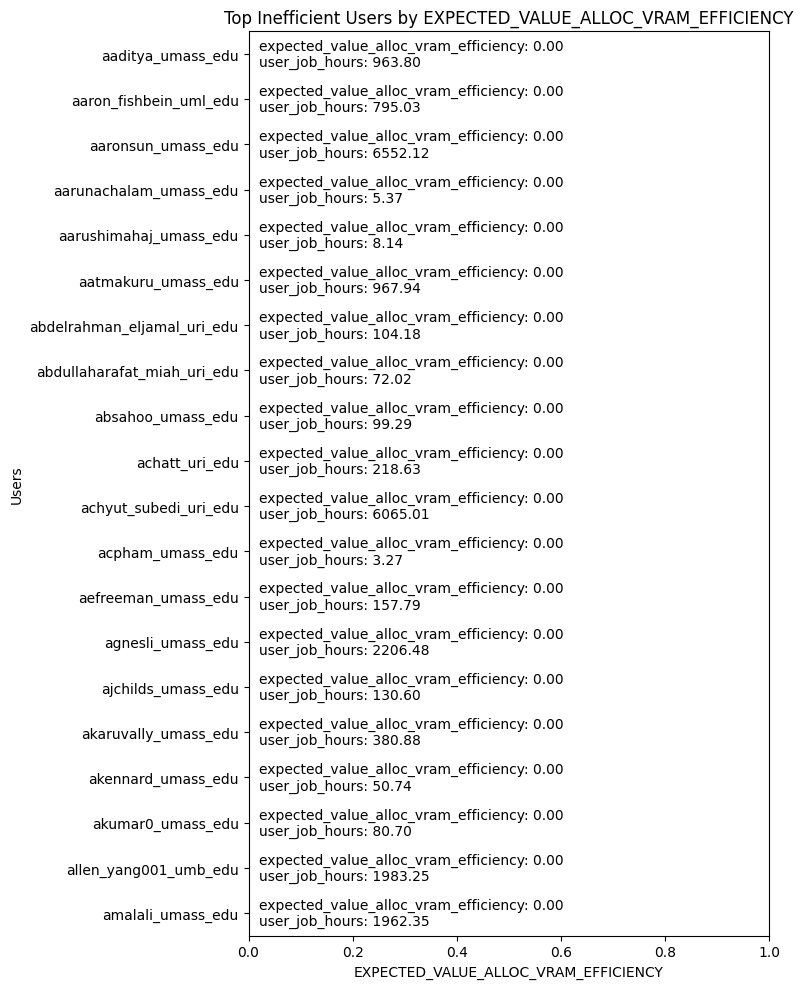

In [11]:
inefficient_users_alloc_vram_eff = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.USERS,
    sorting_key="expected_value_alloc_vram_efficiency",
    ascending=True,  # we want to find users with low efficiency
    filter_criteria={
        "expected_value_alloc_vram_efficiency": {"max": 0.3, "inclusive": True},
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a user
    }
)
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users_alloc_vram_eff.head(20))

# Plot top inefficient users by allocated vram efficiency, with allocated vram efficiency as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_alloc_vram_eff.head(20))
users_with_metrics_visualizer.visualize(
    column="expected_value_alloc_vram_efficiency",
    bar_label_columns=["expected_value_alloc_vram_efficiency", "user_job_hours"],
    figsize=(8, 10)
)


Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
1,aaditya_umass_edu,125,963.803333,pi_dganesan_umass_edu,<NA>,<NA>,0.0,<NA>,44.703554,43085.434444
3,aaron_fishbein_uml_edu,47,795.030833,pi_erno_sajo_uml_edu,<NA>,<NA>,0.0,<NA>,818.367001,73026.567778
4,aaronsun_umass_edu,190,6552.118611,pi_smaji_umass_edu,<NA>,<NA>,0.0,<NA>,55.227180,230986.070278
5,aarunachalam_umass_edu,6,5.371389,pi_etaffet_umass_edu,<NA>,<NA>,0.0,<NA>,11.813053,63.452500
6,aarushimahaj_umass_edu,5,8.141667,pi_burleson_umass_edu,<NA>,<NA>,0.0,<NA>,19.307131,157.192222
9,aatmakuru_umass_edu,41,967.938889,pi_hzamani_umass_edu,<NA>,<NA>,0.0,<NA>,246.934935,62170.558889
10,abdelrahman_eljamal_uri_edu,12,104.180556,pi_csc592_uri_edu,<NA>,<NA>,0.0,<NA>,522.180728,7816.421667
11,abdullaharafat_miah_uri_edu,6,72.018889,pi_yu_bi_uri_edu,<NA>,<NA>,0.0,<NA>,598.045285,12339.890278
15,absahoo_umass_edu,47,99.285833,pi_mccallum_umass_edu,<NA>,<NA>,0.0,<NA>,35.072840,3482.236111
18,achatt_uri_edu,7,218.631111,pi_csc561_uri_edu,<NA>,<NA>,0.0,<NA>,542.327065,17513.455556


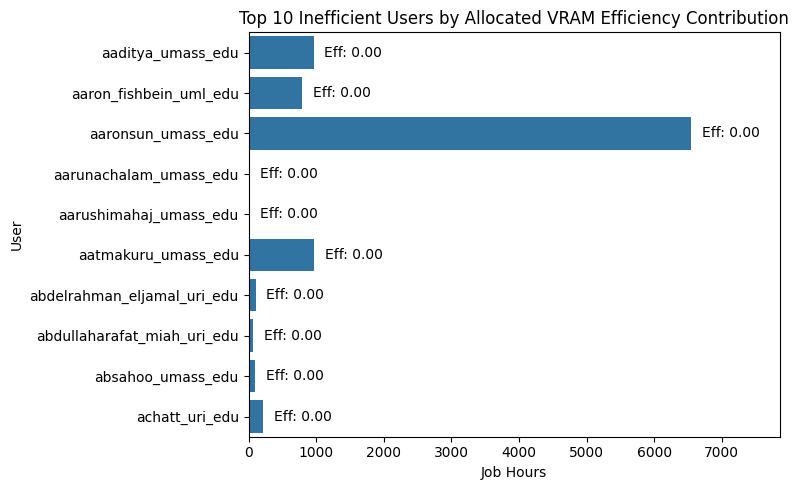

In [12]:
inefficient_users = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.USERS,
    sorting_key="expected_value_alloc_vram_efficiency",
    ascending=True,  # we want to find users with low efficiency
    filter_criteria={
        "expected_value_alloc_vram_efficiency": {"max": 0.3, "inclusive": True},
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a user
    }
)

# Display top inefficient users by job count
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users.head(10))


# Plot top inefficient users by GPU hours, with efficiency as labels
top_users = inefficient_users.head(10)

plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    y=top_users["User"],
    x=top_users["user_job_hours"],
    orient="h"
)
plt.xlabel("Job Hours")
plt.ylabel("User")
plt.title("Top 10 Inefficient Users by Allocated VRAM Efficiency Contribution")

# Annotate bars with expected_value_alloc_vram_efficiency, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_users["user_job_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.20 if xmax > 0 else 1
ax.set_xlim(0, xlim)

# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (job_hours, efficiency) in enumerate(
    zip(
        top_users["user_job_hours"],
        top_users["expected_value_alloc_vram_efficiency"],
        strict=True,
    )
):
    # Place annotation at min(job_hours + 2% of xlim, 98% of xlim)
    xpos = min(job_hours + xlim * 0.02, xlim * 0.98)
    # If bar is very close to right spine, nudge annotation left to avoid overlap
    if xpos > xlim * 0.96:
        xpos = xlim * 0.96
    ax.text(
        xpos,
        i,
        f"Eff: {efficiency:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )

plt.tight_layout()
plt.show()

#### <a id='toc1_2_2_2_'></a>[Find Inefficient Users based on `vram_hours`](#toc0_)


Top inefficient users by VRAM-hours:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count,vram_hours
758,zhangl_uri_edu,339,54019.047778,pi_zhangl_uri_edu,<NA>,<NA>,0.0,<NA>,1203.654329,1.058721e+07
513,qhe_smith_edu,32,2836.876667,pi_hrando_smith_edu,<NA>,<NA>,0.0,<NA>,43462.765699,1.941339e+06
236,ibrahim_isah_student_uml_edu,101,2537.676389,pi_stephen_lam_uml_edu,<NA>,<NA>,0.0,<NA>,42256.802331,1.916344e+06
303,juhyeonlee_umass_edu,699,22252.957778,pi_sunghoonlee_umass_edu,<NA>,<NA>,0.0,<NA>,588.464501,1.867289e+06
187,ejdwight_umass_edu,87,12602.062222,pi_candela_umass_edu,<NA>,<NA>,0.0,<NA>,1490.736878,1.788745e+06
207,gkhanna_uri_edu,989,46149.722222,pi_gkhanna_uri_edu,<NA>,<NA>,0.0,<NA>,207.062930,1.709523e+06
556,sbarethiya_umass_edu,1710,20681.052222,pi_jianhanc_umass_edu,<NA>,<NA>,0.0,<NA>,496.869296,1.346179e+06
168,dmohapatra_umass_edu,6936,30083.512778,pi_dmohapatra_umass_edu,<NA>,<NA>,0.0,<NA>,31.320584,9.339274e+05
547,rvmathew_umass_edu,61013,79656.377222,pi_grason_umass_edu,<NA>,<NA>,0.0,<NA>,11.000000,8.762201e+05
562,sdandekar_umass_edu,169,3670.678889,pi_sniekum_umass_edu,<NA>,<NA>,0.0,<NA>,811.051775,8.303352e+05


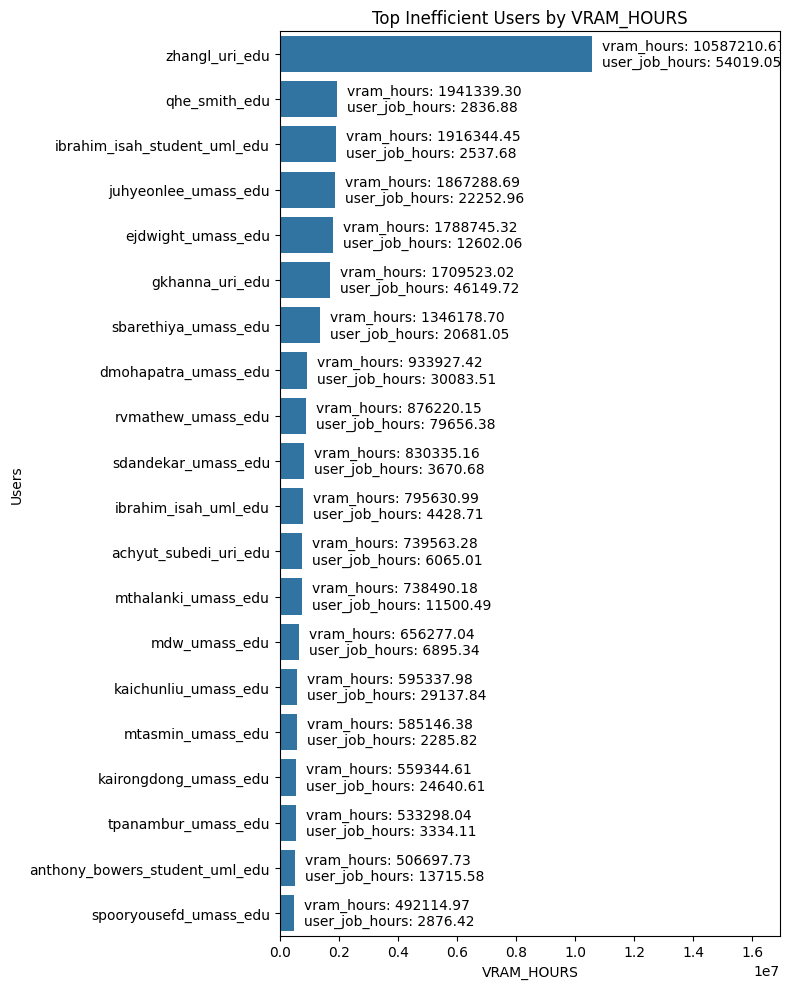

In [13]:
inefficient_users_vram_hours = efficiency_analysis.find_inefficient_users_by_vram_hours(
    vram_hours_filter={"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
    min_jobs=5,  # Minimum number of jobs to consider a user
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient users by VRAM-hours:")
display(inefficient_users_vram_hours.head(20))


# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_vram_hours.head(20))
users_with_metrics_visualizer.visualize(
    column="vram_hours",
    bar_label_columns=["vram_hours", "user_job_hours"],
    figsize=(8, 10)
)

### <a id='toc1_2_3_'></a>[PI Group Efficiency Metrics](#toc0_)

In [14]:
pi_accounts_with_metrics

,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count
0,pi_hongyu_umass_edu,449,2666.390833,32,124811.512222,<NA>,<NA>,0.0,<NA>,2929.500153
1,pi_mduarte_umass_edu,25,127.703889,2,1817.808611,<NA>,<NA>,0.0,<NA>,14.357974
2,pi_grason_umass_edu,61013,79656.377222,1,876220.149444,<NA>,<NA>,0.0,<NA>,11.000000
3,pi_sumientra_rampersad_umb_edu,31,345.524722,2,21077.725556,<NA>,<NA>,0.0,<NA>,234.804918
4,pi_farkas_umass_edu,1,5.419167,1,59.610833,<NA>,<NA>,0.0,<NA>,11.000000
...,...,...,...,...,...,...,...,...,...,...
256,pi_sbischof_umass_edu,8,63.049444,2,1302.066667,<NA>,<NA>,0.0,<NA>,38.114076
257,pi_bps542_uri_edu,10,44.104444,3,1998.964167,<NA>,<NA>,0.0,<NA>,224.569700
258,pi_annagreen_umass_edu,393,3084.936944,5,630655.373056,<NA>,<NA>,0.0,<NA>,875.772888
259,pi_jtaneja_umass_edu,1515,10848.431389,11,240904.461111,<NA>,<NA>,0.0,<NA>,128.760263


#### <a id='toc1_2_3_1_'></a>[Find Inefficient PIs based on `vram_hours`](#toc0_)


Top inefficient PI Groups by VRAM-hours:


,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_vram_constraint_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_vram_constraint_efficiency,expected_value_gpu_count
80,pi_zhangl_uri_edu,346,54992.146667,3,1.089500e+07,<NA>,<NA>,0.0,<NA>,1205.747786
194,pi_stephen_lam_uml_edu,390,9864.405,6,2.804132e+06,<NA>,<NA>,0.0,<NA>,29273.777930
100,pi_sunghoonlee_umass_edu,5664,55604.080278,10,2.542599e+06,<NA>,<NA>,0.0,<NA>,439.179485
82,pi_jianhanc_umass_edu,3354,73973.837222,5,2.247700e+06,<NA>,<NA>,0.0,<NA>,320.050138
10,pi_hrando_smith_edu,44,2864.072778,5,1.942784e+06,<NA>,<NA>,0.0,<NA>,43430.605227
185,pi_candela_umass_edu,96,12609.5575,2,1.788877e+06,<NA>,<NA>,0.0,<NA>,1490.628827
183,pi_gkhanna_uri_edu,1057,46710.241667,6,1.720510e+06,<NA>,<NA>,0.0,<NA>,206.048521
207,pi_sniekum_umass_edu,341,4586.987222,5,1.005028e+06,<NA>,<NA>,0.0,<NA>,825.742787
201,pi_dmohapatra_umass_edu,6936,30083.512778,1,9.339274e+05,<NA>,<NA>,0.0,<NA>,31.320584
2,pi_grason_umass_edu,61013,79656.377222,1,8.762201e+05,<NA>,<NA>,0.0,<NA>,11.000000


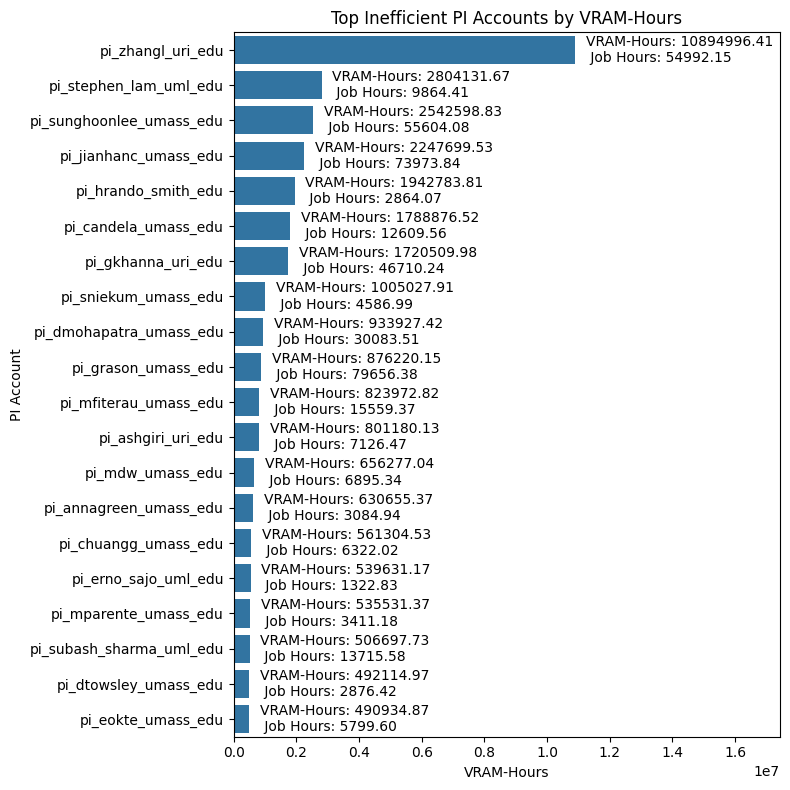

In [15]:
inefficient_pis_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.PI_GROUPS,
    sorting_key="pi_acc_vram_hours",
    ascending=False,
    filter_criteria={
        "pi_acc_vram_hours": {"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a PI account
    }
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient PI Groups by VRAM-hours:")
display(inefficient_pis_vram_hours.head(20))

top_pi_accounts = inefficient_pis_vram_hours.head(20)

# Plot top inefficient users by VRAM-hours, with VRAM-hours as labels
plt.figure(figsize=(8, 8))
barplot = sns.barplot(
    y=top_pi_accounts["pi_account"],
    x=top_pi_accounts["pi_acc_vram_hours"],
    order=top_pi_accounts["pi_account"].tolist(),  # Only show present values
    orient="h"
)
plt.xlabel("VRAM-Hours")
plt.ylabel("PI Account")
plt.title("Top Inefficient PI Accounts by VRAM-Hours")
# Annotate bars with gpu_hours, keeping text fully inside the plot's right spine
ax = barplot
xmax = top_pi_accounts["pi_acc_vram_hours"].max()
# Add headroom for annotation space (20% extra)
xlim = xmax * 1.6 if xmax > 0 else 1
ax.set_xlim(0, xlim)
# Calculate annotation x-position: place at 98% of xlim or just left of the right spine, whichever is smaller
for i, (vram_hours, pi_acc_job_hours) in enumerate(
    zip(
        top_pi_accounts["pi_acc_vram_hours"],
        top_pi_accounts["pi_acc_job_hours"],
        strict=True,
    )
):
    # Place annotation at min(vram_hours + 2% of xlim, 98% of xlim)
    xpos = min(vram_hours + xlim * 0.02, xlim * 0.98)
    ax.text(
        xpos,
        i,
        f"VRAM-Hours: {vram_hours:.2f}\n Job Hours: {pi_acc_job_hours:.2f}",
        va="center",
        ha="left",
        fontsize=10,
        color="black",
        clip_on=True
    )
plt.tight_layout()
plt.show()

## <a id='toc1_3_'></a>[Example: Analyze all jobs with no VRAM constraints](#toc0_)

In [16]:
# Filter jobs where no VRAM constraint was set but a GPU was allocated
no_vram_constraint_efficiency_analysis = ea.EfficiencyAnalysis(
	jobs_df=preprocessed_jobs_df
)
all_no_vram_constraint_jobs = no_vram_constraint_efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter={"min": 0, "inclusive": False},  # No VRAM constraints
    gpu_count_filter={"min": 1, "inclusive": True},  # At least one GPU allocated
    gpu_mem_usage_filter={"min": 0, "inclusive": False}  # Used more than 0 GiB of VRAM
)

display(all_no_vram_constraint_jobs.head(10))
print(all_no_vram_constraint_jobs.shape)

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs
255,38736455,<NA>,-1,submit_el_job.sh,False,non-interactive,pi_wenlongzhao_umass_edu,aranade_umass_edu,"['a40', 'a100', 'l40s', 'gpu:a40']",normal,...,99.0,2.486796e+10,25.099121,0 days 01:31:06,48,<NA>,48,48,91,15086
260,38744217,<NA>,-1,nf-COLABFOLD_COLABFOLD_BATCH_(Q9A3A9-J3SMN7),False,non-interactive,pi_pchien_umass_edu,pchien_umass_edu,['vram40'],normal,...,100.0,3.505858e+10,99.812378,0 days 02:37:22,40,<NA>,40,48,46119,56541
262,38750103,<NA>,-1,interactive,False,shell,pi_rrahimi_umass_edu,kwhitecross_umass_edu,['vram80'],normal,...,400.0,4.025245e+11,18.408882,0 days 00:00:09,320,320,320,320,325,2265
326,38754139,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_dganesan_umass_edu,aaditya_umass_edu,['vram48'],normal,...,9.0,9.452483e+09,0.632963,0 days 00:00:24,48,<NA>,48,48,301,2691
328,38754150,<NA>,-1,no-shell,False,shell,pi_hongyu_umass_edu,smachcha_umass_edu,['vram40'],normal,...,99.0,5.062453e+10,11.699689,0 days 00:00:11,40,<NA>,40,48,151,11215
331,38754613,<NA>,-1,bash,False,shell,pi_hongyu_umass_edu,pkphan_umass_edu,"['l40s', 'a100-40g', 'a40', 'a100-80g']",normal,...,94.0,2.458378e+09,55.363029,0 days 00:00:03,80,<NA>,80,48,776,11215
333,38754623,<NA>,-1,bash,False,shell,pi_hongyu_umass_edu,pkphan_umass_edu,"['l40s', 'a100-40g', 'a40', 'a100-80g']",normal,...,96.0,2.399183e+09,48.035259,0 days 00:00:25,80,<NA>,80,48,776,11215
344,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,...,27.0,1.110556e+11,3.993254,0 days 00:00:26,40,80,80,80,140,9822
346,38755748,<NA>,-1,no-shell,False,shell,pi_hongyu_umass_edu,smachcha_umass_edu,['vram40'],normal,...,98.0,1.073582e+11,2.106255,0 days 00:00:09,40,<NA>,40,48,151,11215
382,38760991,<NA>,-1,sys/dashboard/sys/bc_vscode,False,bc_vscode,pi_wenlongzhao_umass_edu,aabedeen_umass_edu,['vram40'],normal,...,28.0,6.090973e+09,8.811755,0 days 00:00:08,40,<NA>,40,48,771,15086


(240873, 33)


### <a id='toc1_3_1_'></a>[Job Efficiency Metrics](#toc0_)

In [17]:
no_vram_constraint_jobs_with_metrics = no_vram_constraint_efficiency_analysis.calculate_job_efficiency_metrics(
    all_no_vram_constraint_jobs
    )

# Set option to display all columns
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(no_vram_constraint_jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option('display.max_columns')
print(f"Jobs found: {len(no_vram_constraint_jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
255,38736455,<NA>,-1,submit_el_job.sh,False,non-interactive,pi_wenlongzhao_umass_edu,aranade_umass_edu,"['a40', 'a100', 'l40s', 'gpu:a40']",normal,TIMEOUT,SUCCESS,2025-06-26 14:43:51,2025-06-26 16:14:57,0 days 08:00:14,0 days 00:08:00,gpu,[gpu009],4,1,{'a40': 1},4.646450e+10,99.0,25.099121,0 days 01:31:06,48,<NA>,48,48,91,15086,8.003889,384.186667,43.273438,0.901530,0.90153,-39.825565,-39.825565,23.160091,48.0,0.482502
260,38744217,<NA>,-1,nf-COLABFOLD_COLABFOLD_BATCH_(Q9A3A9-J3SMN7),False,non-interactive,pi_pchien_umass_edu,pchien_umass_edu,['vram40'],normal,COMPLETED,SUCCESS,2025-06-26 15:47:49,2025-06-26 18:25:11,0 days 05:37:53,0 days 00:16:00,gpu,[gypsum-gpu188],1,1,{'rtx_8000': 1},3.879731e+08,100.0,99.812378,0 days 02:37:22,40,<NA>,40,48,46119,56541,5.631389,270.306667,0.361328,0.007528,0.009033,-1321.575194,-1272.292462,32.650845,72.0,0.453484
262,38750103,<NA>,-1,interactive,False,shell,pi_rrahimi_umass_edu,kwhitecross_umass_edu,['vram80'],normal,TIMEOUT,SUCCESS,2025-06-26 16:21:10,2025-06-26 16:21:19,0 days 08:00:21,0 days 00:08:00,superpod-a100,[gpu015],16,4,{'a100': 4},3.299974e+11,400.0,18.408882,0 days 00:00:09,320,320,320,320,325,2265,32.023333,10247.466667,307.333984,0.960419,0.960419,-413.8536,-413.8536,374.880127,500.0,0.749760
326,38754139,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,pi_dganesan_umass_edu,aaditya_umass_edu,['vram48'],normal,TIMEOUT,SUCCESS,2025-06-26 17:12:01,2025-06-26 17:12:25,0 days 08:00:15,0 days 00:08:00,gpu,[gypsum-gpu182],12,1,{'rtx_8000': 1},1.281360e+09,9.0,0.632963,0 days 00:00:24,48,<NA>,48,48,301,2691,8.004167,384.2,1.193359,0.024862,0.024862,-1419.399498,-1419.399498,8.803310,32.0,0.275103
328,38754150,<NA>,-1,no-shell,False,shell,pi_hongyu_umass_edu,smachcha_umass_edu,['vram40'],normal,TIMEOUT,SUCCESS,2025-06-26 17:14:47,2025-06-26 17:14:58,0 days 08:00:12,0 days 00:08:00,gpu,[gypsum-gpu188],4,1,{'rtx_8000': 1},4.599683e+10,99.0,11.699689,0 days 00:00:11,40,<NA>,40,48,151,11215,8.003333,384.16,42.837891,0.892456,1.070947,-43.708958,26.331691,47.147766,100.0,0.471478
331,38754613,<NA>,-1,bash,False,shell,pi_hongyu_umass_edu,pkphan_umass_edu,"['l40s', 'a100-40g', 'a40', 'a100-80g']",normal,TIMEOUT,SUCCESS,2025-06-26 17:30:10,2025-06-26 17:30:13,0 days 08:00:28,0 days 00:08:00,gpu-preempt,[ials-gpu034],10,1,{'l40s': 1},4.009755e+09,94.0,55.363029,0 days 00:00:03,80,<NA>,80,48,776,11215,8.007778,384.373333,3.734375,0.077799,0.04668,-981.54364,-1177.891388,2.289543,30.0,0.076318
333,38754623,<NA>,-1,bash,False,shell,pi_hongyu_umass_edu,pkphan_umass_edu,"['l40s', 'a100-40g', 'a40', 'a100-80g']",normal,TIMEOUT,SUCCESS,2025-06-26 17:31:20,2025-06-26 17:31:45,0 days 08:00:25,0 days 00:08:00,gpu-preempt,[ials-gpu035],10,1,{'l40s': 1},3.946840e+09,96.0,48.035259,0 days 00:00:25,80,<NA>,80,48,776,11215,8.006944,384.333333,3.675781,0.076579,0.045947,-987.51964,-1183.846954,2.234413,30.0,0.074480
344,38755106,<NA>,-1,interactive,False,shell,pi_hzamani_umass_edu,mrafiee_umass_edu,['vram40'],normal,TIMEOUT,SUCCESS,2025-06-26 18:16:35,2025-06-26 18:17:01,0 days 08:00:10,0 days 00:08:00,superpod-a100,[gpu013],8,1,{'a100': 1},1.525049e+10,27.0,3.993254,0 days 00:00:26,40,80,80,80,140,9822,8.002778,640.222222,14.203125,0.177539,0.355078,-1106.665485,-662.897256,103.428574,200.0,0.517143
346,38755748,<NA>,-1,no-shell,False,shell,pi_hongyu_umass_edu,smachcha_umass_edu,['vram40'],normal,TIMEOUT,SUCCESS,2025-06-26 18:24:01,2025-06-26 18:24:10,0 days 08:00:02,0 days 00:08:00,gpu

Jobs found: 240873


#### <a id='toc1_3_1_1_'></a>[Problem with duplicate JobIDs](#toc0_)

In [18]:
# select jobs with specific job id
pd.set_option('display.max_columns', None)
# Display the DataFrame
display(no_vram_constraint_jobs_with_metrics[no_vram_constraint_jobs_with_metrics["JobID"] == 24374463])
pd.reset_option('display.max_columns')

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,CPUs,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,user_jobs,account_jobs,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
10462163,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-09-03 15:33:56,2024-09-04 02:12:01,0 days 02:08:20,0 days 02:48:00,gpu-preempt,"[gpu018, gpu019]",224,16,{'a100': 16},6.174015e+09,99.0,1.398886,0 days 10:38:05,640,<NA>,640,1280,22,35,34.222222,43804.444444,5.75,0.004492,0.008984,-236781.223061,-206418.295898,57.617062,512.0,0.112533
10470614,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-29 20:02:59,2024-08-31 13:08:52,3 days 02:24:57,0 days 02:48:00,gpu-preempt,"[gpu014, gpu018]",224,16,{'a100': 16},6.174015e+09,100.0,1.425578,1 days 17:05:53,640,<NA>,640,1280,22,35,1190.653333,1524036.266667,5.75,0.004492,0.008984,-8238049.261609,-7181667.820298,57.735668,512.0,0.112765
10505399,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-28 00:04:02,2024-08-28 12:01:14,1 days 08:01:37,0 days 02:48:00,gpu-preempt,"[gpu020, gpu021]",224,16,{'a100': 16},6.174015e+09,100.0,1.419882,0 days 11:57:12,640,<NA>,640,1280,22,35,512.431111,655911.822222,5.75,0.004492,0.008984,-3545475.931854,-3090832.501584,57.736538,512.0,0.112767
10519733,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-23 20:50:50,2024-08-24 05:52:24,3 days 18:11:35,0 days 02:48:00,gpu-preempt,"[gpu017, gpu020]",224,16,{'a100': 16},6.174015e+09,100.0,1.419324,0 days 09:01:34,640,<NA>,640,1280,22,35,1443.088889,1847153.777778,5.75,0.004492,0.008984,-9984633.665171,-8704284.232043,57.648254,512.0,0.112594
10574518,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-21 15:08:27,2024-08-22 12:51:25,1 days 07:59:17,0 days 02:48:00,gpu-preempt,"[gpu020, gpu021]",224,16,{'a100': 16},6.174015e+09,100.0,1.420042,0 days 21:42:58,640,<NA>,640,1280,22,35,511.808889,655115.377778,5.75,0.004492,0.008984,-3541170.818707,-3087079.441659,57.734287,512.0,0.112762
10630531,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,PREEMPTED,SUCCESS,2024-08-20 16:15:30,2024-08-21 10:14:09,0 days 04:54:10,0 days 02:48:00,gpu-preempt,"[gpu020, gpu021]",224,16,{'a100': 16},6.174015e+09,99.0,1.427450,0 days 17:58:39,640,<NA>,640,1280,22,35,78.444444,100408.888889,5.75,0.004492,0.008984,-542751.764549,-473153.626313,57.712429,512.0,0.112720


#### <a id='toc1_3_1_2_'></a>[Top users with most number of jobs that have no VRAM constraints](#toc0_)

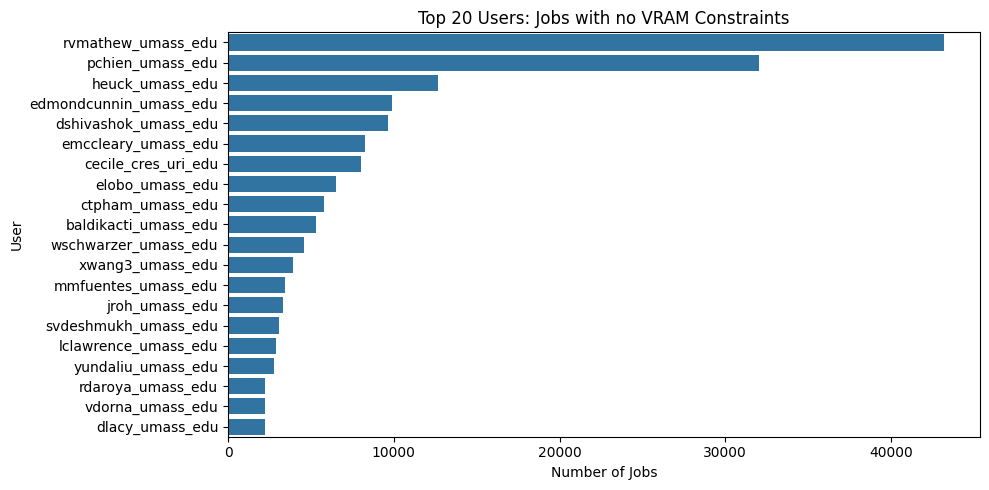

In [19]:
# Plot top users by number of jobs with no VRAM constraints
if not all_no_vram_constraint_jobs.empty:
    plt.figure(figsize=(10, 5))
    user_counts = all_no_vram_constraint_jobs["User"].value_counts().head(20)
    sns.barplot(x=user_counts.values, y=user_counts.index, orient="h")
    plt.xlabel("Number of Jobs")
    plt.ylabel("User")
    plt.title("Top 20 Users: Jobs with no VRAM Constraints")
    plt.tight_layout()
    plt.show()
else:
    print("No jobs found without VRAM constraints.")

#### <a id='toc1_3_1_3_'></a>[Find inefficient jobs with no VRAM Constraints based on `alloc_vram_efficiency_score`](#toc0_)


Top inefficient Jobs by allocated VRAM efficiency score:


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,vram_constraint_efficiency,alloc_vram_efficiency_score,vram_constraint_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency
10519733,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,1443.088889,1847153.777778,5.750000,0.004492,0.008984,-9984633.665171,-8704284.232043,57.648254,512.0,0.112594
10470614,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,1190.653333,1524036.266667,5.750000,0.004492,0.008984,-8238049.261609,-7181667.820298,57.735668,512.0,0.112765
10822396,24009623,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7543', 'amd7702', ...",normal,...,590.542222,755894.044444,5.728516,0.004475,0.008951,-4088751.007772,-3564805.182063,45.587269,512.0,0.089038
10505399,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,512.431111,655911.822222,5.750000,0.004492,0.008984,-3545475.931854,-3090832.501584,57.736538,512.0,0.112767
10574518,24374463,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,511.808889,655115.377778,5.750000,0.004492,0.008984,-3541170.818707,-3087079.441659,57.734287,512.0,0.112762
804575,37751772,<NA>,-1,train-70M-RVV-dec-300B,False,non-interactive,pi_hadi_amiri_uml_edu,mohamed_elgaar_student_uml_edu,['a100-80g'],normal,...,768.08,983142.4,54.638672,0.042686,0.042686,-3100706.711723,-3100706.711723,12.704948,176.0,0.072187
804574,37750425,<NA>,-1,train-70M-RVV-dec-300B,False,non-interactive,pi_hadi_amiri_uml_edu,mohamed_elgaar_student_uml_edu,['a100-80g'],normal,...,768.115556,983187.911111,54.814453,0.042824,0.042824,-3097692.254144,-3097692.254144,12.604267,176.0,0.071615
768363,37749568,<NA>,-1,train-70M-RVV-dec-300B,False,non-interactive,pi_hadi_amiri_uml_edu,mohamed_elgaar_student_uml_edu,['a100-80g'],normal,...,745.924444,954783.288889,54.603516,0.042659,0.042659,-3011880.199659,-3011880.199659,12.703892,176.0,0.072181
10615160,24374462,<NA>,-1,ADISeN,False,non-interactive,pi_hendawi_uri_edu,kyle_demedeiros_uri_edu,"['amd1900x', 'amd7402', 'amd7502', 'amd7543', ...",normal,...,1082.04,692505.6,8.451172,0.013205,0.02641,-2996584.651972,-2516576.34781,57.801441,512.0,0.112893
791253,37752650,<NA>,-1,train-70M-RVV-dec-300B,False,non-interactive,pi_hadi_amiri_uml_edu,mohamed_elgaar_student_uml_edu,['a100-80g'],normal,...,338.093333,432759.466667,1.947266,0.001521,0.001521,-2807825.303014,-2807825.303014,4.486153,176.0,0.025490


Minimum value for alloc_vram_efficiency_score: -9984633.665170714


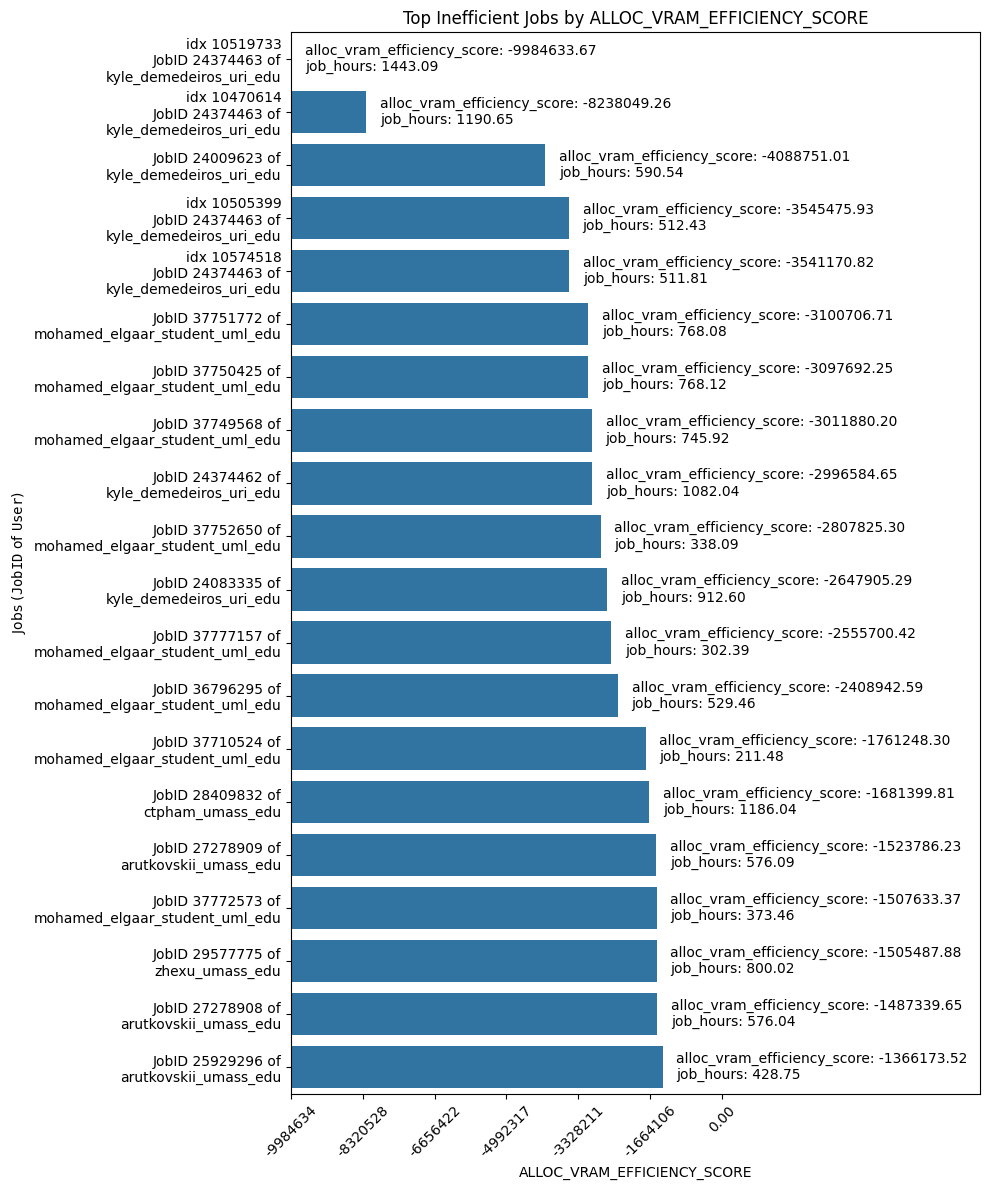

In [20]:
low_alloc_vram_score_jobs = no_vram_constraint_efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=ea.MetricsDataFrameNameEnum.JOBS,
    sorting_key="alloc_vram_efficiency_score",
    ascending=True,  # Sort by alloc_vram_efficiency_score in ascending order
    filter_criteria={
        "alloc_vram_efficiency_score": {"max": -10, "inclusive": True},  # score threshold
    }
)
# Display top inefficient users by alloc_vram_efficiency_score
print("\nTop inefficient Jobs by allocated VRAM efficiency score:")

display(low_alloc_vram_score_jobs.head(20))

jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(low_alloc_vram_score_jobs.head(20))
jobs_with_metrics_visualizer.visualize(
    column="alloc_vram_efficiency_score",
    bar_label_columns=["alloc_vram_efficiency_score", "job_hours"],
    figsize=(10, 12)
)

In [24]:
efficiency_analysis.categorize_jobs_by_vram_constraint_efficiency()

,job_count,percentage
vram_constraint_efficiency_bucket,,
NA,123445,100.0
